<a href="https://colab.research.google.com/github/AklimaRimi/Reptile-Museum/blob/main/notebook/final_train_a_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reptile-Museum (Multi-Target Class)

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
! git clone https://github.com/AklimaRimi/Reptile-Museum.git

fatal: destination path 'Reptile-Museum' already exists and is not an empty directory.


## Installing necessary libraries

In [19]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr onnxruntime onnx nbdev wandb
   

In [20]:
!nvidia-smi

Thu Mar 16 10:35:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   5433MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [21]:

from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import pandas as pd
import numpy as np
import torch
from fastai.metrics import accuracy
torch.cuda.is_available()
from fastai.vision.all import *
from fastcore.parallel import *

import torch
import glob2, numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm


## Re-Checking Final CSV File..

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
path = '/content/'

In [22]:
df = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')
df.head()

,Image,Type,Name,Scientific Name,Conservation Status,Habitant,Color,Found In,Diet
0,Reptile-Museum/augimg/Rafetus swinhoei/yRafetus swinhoei85.jpeg,Turtle,Yangtze giant softshell turtle,Rafetus swinhoei,Critically Endangered,River,Olive-Green,China,Omnivore
1,Reptile-Museum/augimg/Scelarcis perspicillata/dScelarcis perspicillata4.jpeg,Lizard,Moroccan rock lizard,Scelarcis perspicillata,Low Risk,Desert,Brown,Morocco,Insectivore
2,Reptile-Museum/augimg/Thamnophis sirtalis parietalis/yThamnophis sirtalis parietalis57.jpeg,Snake,Red-sided garter snake,Thamnophis sirtalis parietalis,Low Risk,Wet Lands,Brown,North America,Carnivore
3,Reptile-Museum/augimg/Caretta caretta/xCaretta caretta82.jpeg,Turtle,Loggerhead sea turtle,Caretta caretta,Low Risk,Ocean,Brown,All Over the World,Carnivore
4,Reptile-Museum/augimg/Mecistops cataphractus/yMecistops cataphractus67.jpeg,Crocodile,West African Slender-snouted crocodile,Mecistops cataphractus,Critically Endangered,Tropical Region,Dark-Brown,Angola,Carnivore


## Setting up Dataloaders for Multi-target classification..

In [41]:
labels = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')

with tf.device('/device:GPU:0'):
  # def get_labels(row):
  #     return [row['Scientific Name'], row['Name'], row['Type'], row['Conservation Status'],row['Habitant'],row['Color'],row['Found In'],row['Diet']]
  # def get_inp(row):
  #   return row['Image']

  dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                      splitter=RandomSplitter(valid_pct=.2,seed=42),
                      get_x=ColReader('Image'),
                      get_y=ColReader(['Scientific Name','Name','Type','Conservation Status','Habitant','Color','Found In','Diet']),
                      item_tfms=Resize(300),
                      
      )
  dls = dblock.dataloaders(labels, bs=34)

## checking how dataloader see my data..

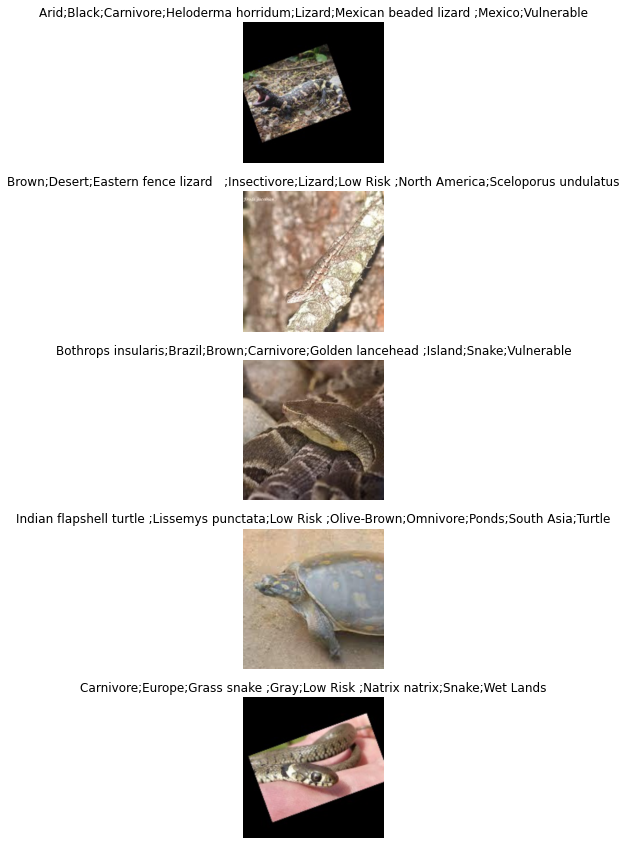

In [42]:
with tf.device('/device:GPU:0'):
  dls.train.show_batch(max_n=5,nrows=5)

## Setting up `cnn_learner` with `resnet34` model using 3 types of metrics in it.
  **Then learning rate would be collected and trained the model**

In [43]:

with tf.device('/device:GPU:0'):
  learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])


In [44]:
learn.freeze()

SuggestedLRs(valley=0.00363078061491251)

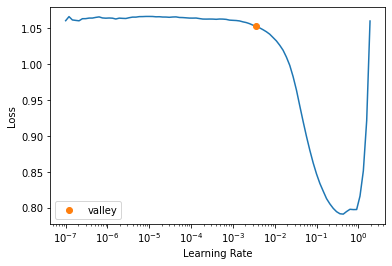

In [45]:
learn.lr_find()

In [46]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(1,0.00363078061491251)



epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.039374,0.029316,0.988846,0.567494,0.814255,06:19


In [47]:
learn.unfreeze()

SuggestedLRs(valley=0.00019054606673307717)

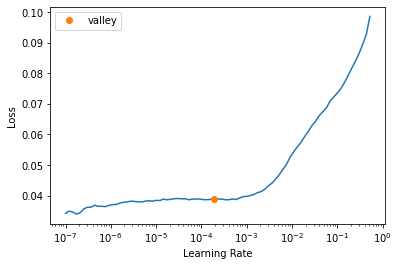

In [48]:
learn.lr_find()

In [49]:
with tf.device('/device:GPU:0'):
  learn.fit_one_cycle(5,0.00019054606673307717)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.031308,0.025297,0.990537,0.623802,0.848951,07:33
1,0.020407,0.018655,0.993084,0.725092,0.899408,07:33
2,0.011897,0.008946,0.996744,0.879960,0.949053,07:33
3,0.006520,0.005805,0.997977,0.925383,0.962473,07:30
4,0.004859,0.005156,0.998209,0.937167,0.966062,07:36


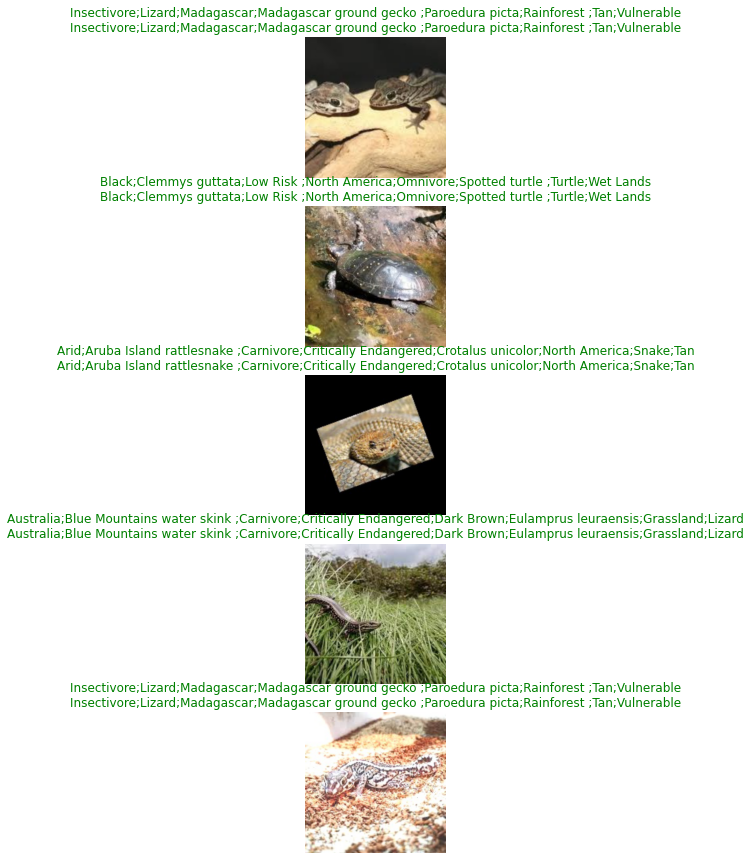

In [50]:
with tf.device('/device:GPU:0'):  
  learn.show_results(figsize=(15,15),max_n=5,nrows=5)

### Saving the learned model as pkl file, and predict.

In [52]:
import pickle
with tf.device('/device:GPU:0'):
  learn.export('/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl',)

In [ ]:
from fastai.vision.all import *

learn  =  load_learner('/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl',)
preds = learn.predict('/content/Reptile-Museum/test images/aAcrantophis madagascariensis21.jpeg')

print(preds[0])


## Trying another model and checking if new model can beat previous model.

In [53]:
with tf.device('/device:GPU:0'):
  learn2 = cnn_learner(dls, xresnet18_deeper, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()])

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

In [54]:
learn2.freeze()

SuggestedLRs(valley=0.0006918309954926372)

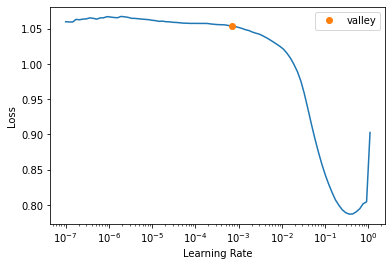

In [55]:
learn2.lr_find()

In [58]:
learn2.fit_one_cycle(1,0.0006918309954926372)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.096177,0.086963,0.977059,0.012078,0.039988,05:22


In [59]:
learn2.unfreeze()

SuggestedLRs(valley=0.0003981071640737355)

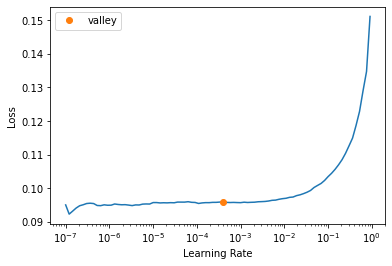

In [60]:
learn2.lr_find()

In [61]:
learn2.fit_one_cycle(5,0.0003981071640737355)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.089016,0.080787,0.977455,0.020032,0.053513,06:04
1,0.072118,0.067660,0.979039,0.072392,0.209399,06:06
2,0.061462,0.055206,0.981356,0.175540,0.449555,06:00
3,0.054013,0.047918,0.983220,0.260257,0.580689,06:06
4,0.050793,0.046256,0.983545,0.262140,0.608593,06:00


## Creating `Dashboard` how Best model trained inside using `Weights and Bias` platform

In [62]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [63]:
wandb.init(project='Reptile-Museum',entity='aklimarimi7',name='resnet34')

accuracy_multi,▁▅▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1_score,▁▆▇██
lr_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [64]:
device = torch.device('cuda')

In [65]:
! pip install -q accelerate

In [66]:
import wandb
from fastai.vision.all import *

from accelerate import notebook_launcher
from fastai.distributed import *
from fastai.callback.wandb import WandbCallback

wandb.require(experiment="service")

def train():
    with tf.device('/device:GPU:0'):
      labels = pd.read_csv('/content/Reptile-Museum/data/final_data.csv')
      dblock = DataBlock(
            blocks=(ImageBlock, MultiCategoryBlock(add_na = True)),
                          splitter=RandomSplitter(valid_pct=.2,seed=0),
                          get_x=ColReader('Image'),
                          get_y=ColReader(['Scientific Name','Name','Type','Conservation Status','Habitant','Color','Found In','Diet']),
                          item_tfms=Resize(300),
                          
          )
      dls = dblock.dataloaders(labels, bs=64)

      learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, F1ScoreMulti(),PrecisionMulti()],cbs=WandbCallback())

      learn.fit(5)

        
notebook_launcher(train, num_processes=2)

Launching training on one GPU.


epoch,train_loss,valid_loss,accuracy_multi,f1_score,precision_score,time
0,0.062441,0.048153,0.983144,0.145046,0.410773,05:47
1,0.038294,0.028821,0.988965,0.568161,0.813527,05:36
2,0.031006,0.023062,0.991196,0.684242,0.904342,05:31
3,0.027643,0.019827,0.992372,0.736408,0.906895,05:35
4,0.024821,0.017688,0.993228,0.779740,0.928139,05:36


WandbCallback was not able to get prediction samples -> Object of type MultiCategory is not JSON serializable


## Best model's size compression using `ONNX`.

In [67]:

dummy_input = torch.randn(1, 3, 300, 300)
torch.onnx.export(learn.model, dummy_input, '/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx', opset_version=14)

RuntimeError: ignored

In [ ]:
import onnx

onnx_model = onnx.load('/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx')

onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime
from onnxruntime import *
from onnxruntime.quantization import quantize_dynamic, QuantType

ort_session = onnxruntime.InferenceSession('/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx')
quantized_model_path = '/content/drive/MyDrive/Multimodal/multi-target/model/quantized_model.onnx'
quantize_dynamic(
    '/content/drive/MyDrive/Multimodal/multi-target/model/model.onnx',
    quantized_model_path,
    weight_type=QuantType.QUInt8,
)
    

## Creating app using `Gradio` for Deployment.

In [ ]:
! pip -q install gradio

In [ ]:
import gradio as gr
from fastai.vision.all import load_learner
from fastai import *
import torch
import os
from PIL import Image



model_path  = '/content/drive/MyDrive/Multimodal/multi-target/model/multi_target_resnet34.pkl'

model = load_learner(model_path)

def result(path):    
  pred,_,probability = model.predict(path)
  return f'{pred[0]}{pred[1]}'

    


In [ ]:
path = '/content/Reptile-Museum/test images/'

image_path = []

for i in os.listdir(path):
  image_path.append(path+i) 


image = gr.inputs.Image(shape =(300,300))
label = gr.outputs.Label()

iface = gr.Interface(fn=result, inputs=image, outputs='text', examples = image_path)
iface.launch(inline = False,share = True,debug=True)